In [1]:
# This is a simplified implementation of the Next Best Action model from
#
# Theocharous, Georgios and Thomas, Philip S. and Ghavamzadeh, Mohammad
# Personalized Ad Recommendation Systems for Life-time Value Optimization with Guarantees
# Proceedings of the 24th International Conference on Artificial Intelligence, 2015
# https://www.ijcai.org/Proceedings/15/Papers/257.pdf

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

events = [
    0, # no action
    1, # visit
    2  # purchase
]
offers = [
    1, # advertisement
    2, # small disocunt
    3  # large discount
]
demogr = [
    0, # low sensitivity
    1  # high sensitivity
]

n = 1000 # users
k = 100  # time intervals
m = 3    # offers
    
def multinomial_int(p):
    return np.where(np.random.multinomial(1, p) == 1)[0][0]

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

def find_offer_times(f):
    return np.nonzero(f)[0]

def offer_seq(f):
    return f[np.where(f > 0)]

In [22]:
def get_event_pr(d, f):
    f_ids = offer_seq(f) 
    f_ids = np.concatenate((f_ids, np.zeros(3 - len(f_ids))))
    
    if((f_ids[0] == 2 and f_ids[1] == 3) or 
       (f_ids[1] == 2 and f_ids[2] == 3) or 
       (f_ids[0] == 2 and f_ids[2] == 3)): 
            p_events = [0.70, 0.08, 0.22]     # higher probability of purchase
    else:
        p_events = [0.90, 0.08, 0.02]         # default
        
    if(np.random.binomial(1, 0.1) > 0):       # add some noise
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

def generate_profiles(n, k, m):
    
    p_offers = [1 / m] * m                                    # offer probabilities (behavioral policy)
    t_offers = np.linspace(0, k, m + 2).tolist()[1 : -1]      # offer campaing times
    t_offer_jit = 5                                           # offer time jitter, standard deviation in time units 
    
    P = np.zeros((n, k))                                      # matrix of profile events
    F = np.zeros((n, k))                                      # offer history
    D = np.zeros((n, 1))                                      # demographic features

    for u in range(0, n):
        D[u, 0] = np.random.binomial(1, 0.5)
    
        # determine m time points to issue offers for customer u
        offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)
        
        for t in range(0, k):                                   # simulate a trajectory for customer u
            if t in offer_times_u:
                F[u, t] = multinomial_int(p_offers) + 1         # issue an offer at time t according 
                                                                # to the behavioral policy 
   
            event = multinomial_int(get_event_pr(D[u], F[u]))   # simulate an event at time t
            P[u, t] = event
        
    return P, F, D

def visualize_profiles(P):
    fig, ax = plt.subplots(figsize=(10, 20))
    chart = ax.imshow(P)
    ax.set_aspect(0.05)
    plt.colorbar(chart, fraction=0.025, pad=0.04, ax=ax)
    plt.show() 

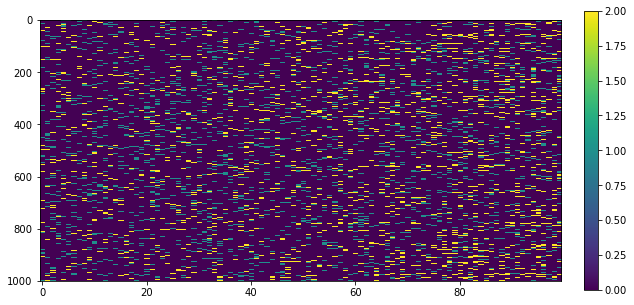

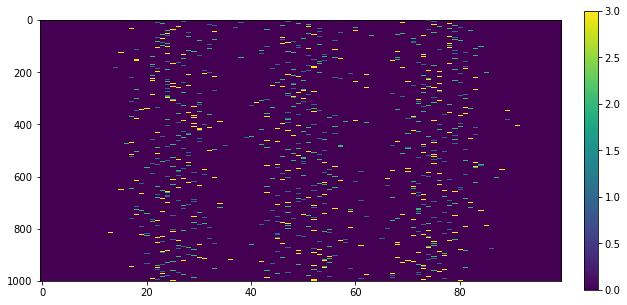

In [23]:
# training set
P, F, D = generate_profiles(n, k, m)
# test set
Pt, Ft, Dt = generate_profiles(n, k, m)

visualize_profiles(P)
visualize_profiles(F)

In [24]:
def state_features(p, f, d, t_start, t_end):
    p_frame = p[0:t_end]
    f_frame = f[0:t_end]
    f1 = index(f_frame, 1, k)  
    f2 = index(f_frame, 2, k)
    f3 = index(f_frame, 3, k)
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # visits
        f1,                    # first time offer 1 was issued
        f2,                    # first time offer 2 was issued
        f3                     # first time offer 3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start:t_end], 2)   # number of purchases in the time frame

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))
    
def prepare_trajectories(P, F, D):
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 
                
            T_u.append([state, action, reward, state_new])
            
        T.append(T_u) 
        
    return np.array(T)
            

In [25]:
T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)

## Policy Learning

In [29]:
# Find the optimal action under a greedy policy and corresponding state value
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

def Q_0(sa):
    return [1]

Q = Q_0
for i in range(1, 6): # FQI iterations
    X = []
    Y = []
    for sample in T.reshape((n * (m + 1), m + 1)):
        x = np.append(sample[0], sample[1]) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, sample[3], offers)
        y = sample[2] + v_best              # reward + value
    
        X.append(x)
        Y.append(y)
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict

In [30]:
print(Q([[0, 0, 100, 100, 100, 1]]))
print(Q([[0, 0, 100, 100, 100, 2]]))
print(Q([[0, 0, 100, 100, 100, 3]]))

print(Q([[0, 0, 100, 20, 100, 1]]))
print(Q([[0, 0, 100, 20, 100, 2]]))
print(Q([[0, 0, 100, 20, 100, 3]]))

print(Q([[0, 0, 100, 20, 50, 1]]))
print(Q([[0, 0, 100, 20, 50, 2]]))
print(Q([[0, 0, 100, 20, 50, 3]]))

[ 14.02501858]
[ 18.08270481]
[ 7.68230699]
[ 18.88533659]
[ 18.88533659]
[ 23.55129004]
[ 28.75390181]
[ 28.75390181]
[ 28.75390181]


In [31]:
# Use test set to evaluate the policy
states = Tt[:, :, 0].flatten().tolist()

In [35]:
values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best) 

In [36]:
s_tsne = TSNE(learning_rate = 100).fit_transform(states)

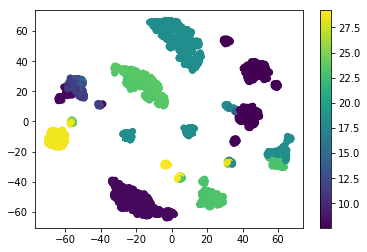

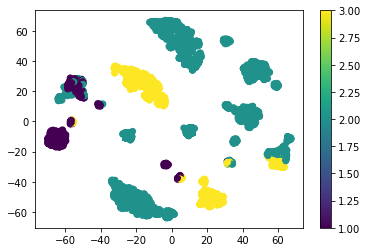

In [37]:
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c=values)
plt.colorbar()
plt.show()

plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c=best_actions)
plt.colorbar()
plt.show()

# Policy Evaluation

FQI provides a way to learn the Q function and derive some policy (e.g. epsilon-greedy) from it. 
If we change the policy, we need to evaluate its performance and. It can be done using historical trajectories.

In [42]:
def make_epsilon_greedy_policy(eps):
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        else:
            return eps / (m - 1)
        
    return egreedy_policy


# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        for transition in trajectory:            
            state, action, reward  = transition[0:3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)   

In [43]:
policy_values = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(e)
    policy_values.append( evaluate_policy_return(T, behavioral_policy, policy) )

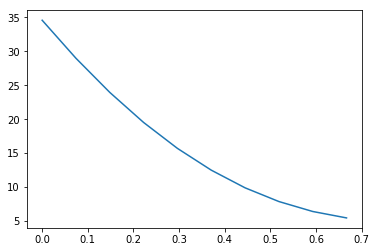

In [44]:
plt.plot(eps, policy_values)
plt.show()